<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import random
import pathlib
from keras import layers
from keras import models
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Data_Entry_2017.csv', encoding='us-ascii')
Findings = df["Finding Labels"].str.split('|')
Findings_list = [word for word_inner in Findings for word in word_inner]
Findings_list = pd.DataFrame(Findings_list, columns=['text'])
Findings_list['text'].value_counts()

No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
Name: text, dtype: int64

In [17]:
test_list = []
with open('test_list.txt', 'r') as f:
    for row in f:
        test_list.append(row.rsplit()[0])

df['test_train'] = df['Image Index'].isin(test_list).apply(
    lambda x: 'test' if x == True else 'train')
df['pos_neg'] = (df['Finding Labels'] !=
                 'No Finding').apply(lambda x: 'pos' if x == True else 'neg')

origin_dir = './images'
dir_tt = ['train', 'test']
dir_pn = ['pos', 'neg']
trashbox_dir = os.path.join(origin_dir, 'trashbox')

for tt in dir_tt:
    for pn in dir_pn:
        dst_dir = os.path.join(origin_dir, tt, pn)
        os.makedirs(dst_dir, exist_ok=True)
        images_folder = os.listdir(origin_dir)
        all_list = list(
            df.query('test_train == @tt and pos_neg == @pn')['Image Index'])
        target_list = [file for file in images_folder if file in all_list]
        for target in target_list:
            sfile = os.path.join(origin_dir, target)
            shutil.move(sfile, dst_dir)

In [18]:
def move_trashbox(prop, keep):
    for tt in dir_tt:
        for pn in dir_pn:
            dst_dir = os.path.join(trashbox_dir, tt, pn)
            src_dir = os.path.join(origin_dir, tt, pn)
            os.makedirs(dst_dir, exist_ok=True)
            src_list = os.listdir(src_dir)
            temp_size = int(len(src_list) * prop)
            temp_list = random.sample(src_list, temp_size)
            if keep == True:
                target_list = [
                    target for target in src_list if target not in temp_list
                ]
            if keep == False:
                target_list = temp_list
            for target in target_list:
                sfile = os.path.join(src_dir, target)
                shutil.move(sfile, dst_dir)


def restore_trashbox(prop):
    for tt in dir_tt:
        for pn in dir_pn:
            dst_dir = os.path.join(origin_dir, tt, pn)
            src_dir = os.path.join(dir_trashbox, tt, pn)
            src_list = os.listdir(src_dir)
            temp_size = int(len(src_list) * prop)
            target_list = random.sample(src_list, temp_size)
            for target in target_list:
                sfile = os.path.join(src_dir, target)
                shutil.move(sfile, dst_dir)

In [19]:
move_trashbox(prop=0.1, keep=True)
#restore_trashbox(prop=1)

In [48]:
k_size = (3, 3)
p_size = (2, 2)
model = models.Sequential()
model.add(
    layers.Conv2D(32, k_size, activation='relu', input_shape=(1024, 1024, 1)))
model.add(layers.MaxPooling2D(p_size))
model.add(layers.Conv2D(64, k_size, activation='relu'))
model.add(layers.MaxPooling2D(p_size))
model.add(layers.Conv2D(64, k_size, activation='relu'))
model.add(layers.MaxPooling2D(p_size))
model.add(layers.Conv2D(128, k_size, activation='relu'))
model.add(layers.MaxPooling2D(p_size))
model.add(layers.Conv2D(128, k_size, activation='relu'))
model.add(layers.MaxPooling2D(p_size))
model.add(layers.Conv2D(256, k_size, activation='relu'))
model.add(layers.MaxPooling2D(p_size))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(
    optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(
#     optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
#     loss='binary_crossentropy',
#     metrics=['accuracy'])

train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

batch_size = 8
file_list = pathlib.Path(os.path.join(origin_dir, 'train'))
file_number = len(list(file_list.glob('**/*.png')))
steps_per_epoch = int(file_number / batch_size)

train_generator = train_datagen.flow_from_directory(
    os.path.join(origin_dir, 'train'),
    target_size=(1024, 1024),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    os.path.join(origin_dir, 'test'),
    target_size=(1024, 1024),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=8,
    validation_data=test_generator,
    validation_steps=batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 1022, 1022, 32)    320       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 511, 511, 32)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 509, 509, 64)      18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 254, 254, 64)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 124, 124, 128)     73856     
__________

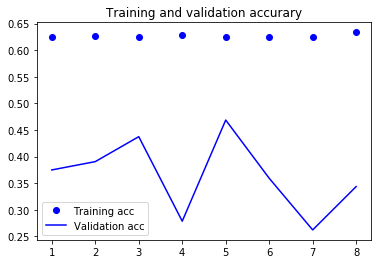

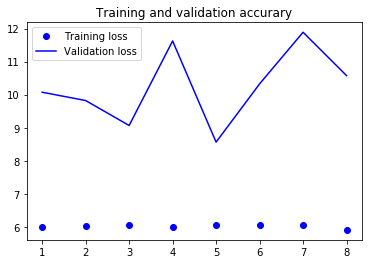

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
ephocs = range(1, len(acc) + 1)
plt.plot(ephocs, acc, 'bo', label='Training acc')
plt.plot(ephocs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accurary')
plt.legend()

plt.figure()

plt.plot(ephocs, loss, 'bo', label='Training loss')
plt.plot(ephocs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accurary')
plt.legend()

plt.show()

In [43]:
y_copy_1 = test_generator.classes.copy()
y_copy_2 = test_generator.classes.copy()
np.random.shuffle(y_copy_1)
float(np.sum(y_copy_1==y_copy_2)/(len(y_copy_1)))

0.49387755102040815